# Causal structure learning with variational autoencoders

*Simon Dirmeier* <*simon.dirmeier @ web.de*> <br> *June 2020*

Learning cause-effect mechanisms among a set of random variables is not only of great epistemological interest, but also a fascinating statistical problem. In this notebook we implement a graph variational autoencoder, called DAG-GNN and published by [Yu *et al.*](https://arxiv.org/abs/1904.10098), to learn the DAG of a structural equations model and compare it to [greedy equivalent search (GES)](http://www.jmlr.org/papers/v3/chickering02b.html) which is one of the state-of-the-art methods for causal discovery.

Feedback and comments are welcome!

In [1]:
suppressMessages({
  library(tensorflow)
  library(tfprobability)
  library(keras)
  library(igraph)
  library(ggraph)
  library(tidyverse)  
  library(cowplot)

  library(pcalg)
})

The goal of causal structure learning is to find the causal ordering of $p$ random variables ${X} = (X_1, \dots, X_p)^T$. For instance, for a pair of random variables $X_1$ and $X_2$, if $X_1$ causes $X_2$, the causal ordering is $X_1 < X_2$. For a set of $p$ random variables the ordering induces a *directed acyclic graph* $\mathcal{G}$ over ${X}$ (in general, if no topological ordering exists, the underlying graph can be cyclic, too, but we limit ourselves to the acyclic case here). Causal structure learning faces some major difficulties though. Some of these are:

- the number of DAGs grows super-exponentially in $p$,
- there may be latent confounding,
- there may be selection bias,
- there may be feedback,
- ...


Score-based methods, such as DAG-GNN or GES, approach the structure learning problem by optimization of a defined score relative to a data set. A drawback of score-based methods is that they often need to assume causal sufficiency (i.e., no latent confounding), that they get stuck in local optimina, and that they need to make several parametric assumptions. 

To learn the causal structure we will need some definitions and assumptions first. A *Bayesian network* represents a joint probability distribution ${P}$ over random variables ${X}$ that factorizes over a DAG $\mathcal{G}$ as

$$\begin{align}
P(X) = \prod_i^p P(X_i \mid \text{pa}_{X_i})
\end{align}$$

The set of conditional independence relations imposed by $\mathcal{G}$ via the above factorization is also called *Markov factorization property*. It also entails that if $X$ and $Y$ are d-separated by $Z$ then $X$ is statistically independent of $Y$ given $Z$. This means that for each of the paths between a variable in ${X}$ and a variable in ${Y}$, there is either a chain $\cdot \rightarrow Z_i \rightarrow \cdot$ or a fork $\cdot \leftarrow Z_i \rightarrow \cdot$ such that $Z_i$ is in ${Z}$, or there is a collider $\cdot \rightarrow W \leftarrow \cdot$ such that neither $W$ nor any of its descendents are in ${Z}$. In general, there can be multiple DAGs that encode the same conditional independence relations which means multiple DAGs can have the same score if the scores are (locally) consistent. As a consequence, one can identify the correct DAG only up to its equivalence class (the completed partially directed acyclic graph).

In order to learn the graph, we will assume having i.i.d. data and a causally sufficient system that does not have cycles. However, even with the two latter assumptions, the problem is still NP-hard.

In the linear Gaussian case, the data generating process of the random variables $X$ reads as

$$\begin{align}
\mathbf{x} & \leftarrow  \mathbf{A}^T \mathbf{x} + \mathbf{z} \\
\end{align}$$

where $\mathbf{A}$ is a $p \times p$-dimensional adjacency matrix that defines the strength of the associations between the variables, and implicitely the causal ordering of the random variables, and $\mathbf{z}$ is a vector of independent error terms. For a data set $\mathbf{X} = \{ \mathbf{x}_i\}_{i=1}^n$ of $n$ realizations of $X$, the linear structural equation model is analogously:

$$\begin{align}
\mathbf{X} & \leftarrow \mathbf{X} \mathbf{A} + \mathbf{Z}
\end{align}$$

which we can rearrange to

$$\begin{align}
\mathbf{X} & \leftarrow \mathbf{Z} \left(\mathbf{I} - \mathbf{A} \right)^{-1}\\
\mathbf{Z} & \leftarrow \mathbf{X} \left(\mathbf{I} - \mathbf{A} \right)
\end{align}$$

where $\mathbf{I}$ is the identity matrix of appropriate dimensions. To learn $\mathbf{A}$ we will use two different approaches:

- a score-based method, DAG-GNN, which is based on graph variational autoencoders and has been introduced by [Yu *et al.*](https://arxiv.org/abs/1904.10098), 
- another score-based method, the GES-algorithm which has been introduced by [Chickering *et al.*](http://www.jmlr.org/papers/v3/chickering02b.html) and which is one of most frequently used method to learn causal DAGs in statistics.

I'll introduce each briefly below and then apply both to data.

## DAG-GNN

Yu *et al.* make use of variational autoencoders for learning the causal structure, i.e., the weighted adjacency matrix $\mathbf{A}$, and for that introduce a new network architecture based on graph neural networks:

$$\begin{align}
\mathbf{X} & \leftarrow f_1 \left( f_2 \left( \mathbf{Z}\right) \left(\mathbf{I} - \mathbf{A} \right)^{-1} \right) \\
\mathbf{Z} & \leftarrow g_1 \left( g_2 \left( \mathbf{X}\right) \left(\mathbf{I} - \mathbf{A} \right) \right)
\end{align}$$

where $f_i$ and $g_j$ are multilayer perceptrons (MLPs). Note that if $f_1$ and $f_2$ were invertible this is just rearranging the formulae as for the linear SEM:

$$\begin{align}
\mathbf{X} & \leftarrow f_1 \left( f_2 \left( \mathbf{Z}\right) \left(\mathbf{I} - \mathbf{A} \right)^{-1} \right) \\
f_1^{-1}(\mathbf{X} ) & \leftarrow  f_2 \left( \mathbf{Z}\right) \left(\mathbf{I} - \mathbf{A} \right)^{-1} \\
f_2 \left( \mathbf{Z}\right) & \leftarrow f_1^{-1}(\mathbf{X} ) \left(\mathbf{I} - \mathbf{A} \right) \\
\mathbf{Z} & \leftarrow f_2^{-1} \left( f_1^{-1}(\mathbf{X} ) \left(\mathbf{I} - \mathbf{A} \right) \right)
\end{align}$$

For their model Yu *et al.* set both $f_2$ and $g_1$ to be identity mappings and $f_1$ and $g_2$ to be MLPs. Hence, the encoder of the VAE which computes the variational posterior $q(Z \mid X)$ has the following form:

$$\begin{align}
q(Z \mid X) &= \mathcal{MN}(\mu_Z, \sigma^2_Z) \\
\left[\mu_Z, \sigma^2_Z\right] & = g_2 \left( \mathbf{X}\right) \left(\mathbf{I} - \mathbf{A} \right)\\
&= \text{MLP}\left(\mathbf{X}, \mathbf{W}_1, \mathbf{W}_2 \right) \left(\mathbf{I} - \mathbf{A} \right)
\end{align}$$

where $\mathcal{MN}$ is the matrix normal, $\text{MLP}\left(\mathbf{X}, \mathbf{W}_1, \mathbf{W}_2 \right) = \text{ReLU}\left(\mathbf{X}\mathbf{W}_1 \right)\mathbf{W}_2$ and $\mathbf{W}_i$ are parameter matrices of appropriate sizes. The decoder which computes the parameters of the hidden likelihood $P(X \mid Z)$ looks like this:

$$\begin{align}
p(X \mid Z) &= \mathcal{MN}(\mu_X, \sigma^2_X) \\
\left[\mu_X, \sigma^2_X\right] & =  f_1  \left( \mathbf{Z} \left(\mathbf{I} - \mathbf{A} \right)^{-1} \right)  \\
& =  \text{MLP}\left(\mathbf{Z}\left(\mathbf{I} - \mathbf{A} \right)^{-1}, \mathbf{W}_3, \mathbf{W}_4 \right)
\end{align}$$

The model is straightforward to implement in `R`. For convenience, we specify a helper function to construct a dense layer first:

In [2]:
dense <- function(name, p, activation = "linear") {
  keras::layer_dense(
    name = name,
    units = p,
    activation = activation,
    use_bias = TRUE,
    kernel_regularizer = keras::regularizer_l2(l = 1),
    kernel_initializer = tf$random_normal_initializer(mean = 0, stddev = 0.1),
    dtype = "float32"
  )
}

The model itself uses `keras_model_custom`:

In [3]:
model <- function(n, p, n_hidden = p) {
  keras_model_custom(function(self) {      
    # init adjacency matrix
    A <- matrix(0, p, p)
    A[upper.tri(A)] <- rnorm(p * (p - 1L) / 2L, 0, 0.1)
    self$A <- tf$Variable(A, name = "A", trainable = TRUE, dtype = "float32")
    self$I <- tf$eye(p, dtype = "float32") # diag for convencience
        
    self$dense_g21 <- dense("g_21", n_hidden, "relu")
    self$dense_g22 <- dense("g_22", p * 2, "linear")    
    self$dense_f11 <- dense("f_11", n_hidden, "relu")
    self$dense_f12 <- dense("f_12", p * 2, "linear")

    # Z = g_2(X) * (I - A)
    self$posterior <- function(x) {
      tri <- self$I - self$A
      z_tilde <- x %>%
        self$dense_g21() %>%
        self$dense_g22() %>%
        tf$split(num_or_size_splits=2L, axis=-1L)
      z_mean <- tf$matmul(z_tilde[[1]], tri)
      z_var  <- tf$matmul(z_tilde[[2]], tri) %>%
        tf$exp()
        
      tfp$distributions$Independent(
        tfp$distributions$Normal(
          loc = z_mean, scale = tf$sqrt(z_var)
        )
      )
    }

    # X = f_1( Z * solve(I - A) )
    self$likelihood <- function(z) {
      tri.inv <- tf$linalg$inv(self$I - self$A)
      x_tilde <- tf$matmul(z, tri.inv) %>%
        self$dense_f11() %>%
        self$dense_f12() %>%
        tf$split(num_or_size_splits=2L, axis=-1L)
      x_mean <- x_tilde[[1]]
      x_var <- tf$exp(x_tilde[[2]])

      tfp$distributions$Independent(
        tfp$distributions$Normal(
          loc = x_mean, scale = tf$sqrt(x_var)
        )
      )
    }

    function(x, mask = NULL, training = FALSE) {
      tf$where(
        tf$math$is_nan(self$A), tf$zeros_like(self$A), self$A
      )
        
      enc <- self$posterior(x)
      z <- enc$sample()
      dec <- self$likelihood(z)
      dec
    }
  })
}

The last part of the model is equivalent to Python's `__call__` member function, i.e., if we construct a model `m` and call `m(X)` on a data set $\mathbf{X}$, it computes the variational posterior, samples from it and then computes the distribution of the decoder.

In [4]:
n <- 100L
p <- 5L
X <- matrix(rnorm(n * p), n)

m <- model(n, p)
m(X)

tfp.distributions.Independent("IndependentNormal/", batch_shape=[100], event_shape=[5], dtype=float32)

The weights of the network are trained by maximizing the evidence low bound

$$\begin{align}
\text{ELBO}(\mathbf{X}) = \mathbb{E}_{q(Z \mid X)} \left[ \log p(X \mid Z) \right] - \text{D}_{\text{KL}} \left( q(Z \mid X) || p(Z)  \right)
\end{align}$$

where we take $p(Z) = \mathcal{MN}(\mathbf{0}, \mathbf{I})$ as the standard matrix normal. In practice we take the expected value of the likelihood using a Monte carlo sample.

The ELBO above, however, does not ensure acyclicity of $\mathbf{A}$, hence the authors introduce an acyclicity constraint to the ELBO:

$$\begin{align}
h(\mathbf{A}) = \text{tr}\left[ \left( \mathbf{I} + \alpha \mathbf{A} \circ \mathbf{A} \right)^p \right] - p = 0
\end{align}$$

for some $\alpha > 0$. Adding this constraint to the ELBO using an augmented Lagrangian method gives us the objective function for the GVAE. The augmented Lagrangian consists of a Lagrange multiplier $\lambda h(\mathbf{A})$ and a quadratic penalty $\frac{c}{2} |h(\mathbf{A})|^2$. The objective we want to optimize is then:

$$\begin{align}
\min - \text{ELBO}(\mathbf{X}) + \lambda h(\mathbf{A}) + \frac{c}{2} ||h(\mathbf{A})||^2
\end{align}$$

The penality can be coded like this:

In [5]:
h <- function(A, alpha) {
  p <- A$shape[[1]]
  I <- tf$eye(p)
    
  e <- I + alpha * tf$math$multiply(A, A)
  er <- e
  for (i in seq(2, p)) {
    er <- tf$matmul(er, e) # since TF does not have a matrix exponential :|
  }

  tf$linalg$trace(er) - p
}

The `R` code for the entire penalized ELBO looks like that:

In [6]:
loss <- function(data, model, alpha, lambda, c) {
  lik_fun <- model(data)
  posterior  <- model$posterior(data)
  prior <- tfp$distributions$Independent(
      tfp$distributions$Normal(
          loc = tf$zeros(c(n, p)), scale = tf$ones(c(n, p))
      )
  )
  
  loglik <- lik_fun$log_prob(data)
  divergence <- tfp$distributions$kl_divergence(posterior, prior)
    
  elbo <- tf$reduce_mean(loglik - divergence)
  lang <- h(model$A, alpha)  
  loss <- -elbo + lambda * lang +  0.5 * c * lang^2  
  loss
}

This pretty much is it. We now only need to define a method to train the parameters which, with Tensorflow 2, can be done like this:

In [7]:
train <- function(data, n_epochs=100, learning_rate=0.1, 
                  threshold=0.05,
                  c=10, lambda=10, alpha=1)
{
    vae <- model(nrow(data), ncol(data))
    data <- tf$cast(data, "float32")
    optimizer <- keras::optimizer_adam(learning_rate)

    for (ep in seq_len(n_epochs)) {
      with(tf$GradientTape() %as% t, {
        lo <- loss(data, vae, alpha, lambda, c)
      })
        
      gradients <- t$gradient(lo, vae$trainable_variables)
      optimizer$apply_gradients(purrr::transpose(list(
        gradients, vae$trainable_variables
      )))      
    }

    A <- tf$math$multiply(vae$A, tf$cast(tf$abs(vae$A) > threshold, "float32"))
    A <- A$numpy()
    colnames(A) <- rownames(A) <- paste0("X", seq(ncol(data)))
    A
}

In my opinion the paper would have benefitted from a couple of additions. Firstly, even though concepts like consistency, score equivalence or faithfulness are mentioned in the introduction the paper does not really discuss them w.r.t their method. Secondly, while popular methods like the PC-algorithm or GES are cited, the authors don't include them in their benchmark. This is especially unfortunate, because both are (pointwise/locally) consistent and should serve as great baseline for large sample sizes. Thirdly, it would probably have made sense to discuss identifiability and what assumptions have to be made to achieve it. For instance, in the linear Gaussian case, returning the CPDAG instead of any DAG in the equivalence class is reasonable, since the true DAG cannot be identified. On the other hand, under specific conditions, such as non-linear or non-Gaussian cases, the true DAG can be identified and returning a DAG makes sense. Finally, since the relationship between the data $\mathbf{X}$ and $\mathbf{A}$ is nonlinear (and nonparametric) in DAG-GNN, interpretation of the coefficients of the weighted adjacency is difficult.

## Greedy equivalence search

Greedy equivalence search (GES,  [Chickering *et al.*](http://www.jmlr.org/papers/v3/chickering02b.html)) is a score-based method working in two phases. The algorithm starts with an empty CPDAG and greedily adds dependencies by considering all possible edges that can be made to the current equivalence class. The first phase stops at a local maximum. In the second phase the algorithm considers all edges that can be removed in the current equivalence class in every step and again stops when a maximum is reached. In the limit (of same size $n$) the algorithm idenfifies the optimal equivalence class, i.e., the optimal CPDAG.

Chickering *et al.* showed that if $P$ is faithful and Markov w.r.t. a DAG $\mathcal{G}$ and the defined score is locally consistent, i.e., the score maxima converge to  an optimal model, then GES outputs the CPDAG of the true causal DAG. That result is insofar remarkable as GES is a *greedy* algorithm. GES assumes causal sufficiency which means that it is in the same *category* of methods as DAG-GNN which is also not able to deal with latent confounding.

The `pcalg` package already implements GES, so we can make use of that

## Use case

We simulate data from a SEM with $p=7$ variables. We can use `pcalg` to first create a DAG and then sample data from it.

In [8]:
n <- 1000L
p <- 7L

set.seed(123)
dag <- pcalg::randomDAG(p, prob = 0.2)

The `dag` object is a `graphNEL`, so we convert it to a matrix first.

In [9]:
A <- dag %>%
    igraph::graph_from_graphnel() %>%
    igraph::as_adj() %>%
    as.matrix()

ordering <- sample(1:p)
A <- A[ordering ,ordering]
colnames(A) <- rownames(A) <- paste0("X", seq(p))

Since the methods above assume acyclicity, we check for it using `igraph`.

In [10]:
igraph::graph_from_adjacency_matrix(A, weighted=TRUE) %>%
  is.dag()

[1] TRUE

We can also check this via the acyclicity constraint, which should be zero if $\mathbf{A}$ has no cycles.

In [11]:
h(tf$convert_to_tensor(A, dtype="float32"), 1)

tf.Tensor(0.0, shape=(), dtype=float32)

As a helper we also define a method to plot a matrix as graph. I personally like `ggraph` for plotting graphs the best

In [12]:
plot.adj <- function(adj) {
  igraph::graph_from_adjacency_matrix(adj, weighted = TRUE) %>%
    ggraph::ggraph(layout = "sugiyama") +
    ggraph::geom_edge_link(
      ggplot2::aes(
        start_cap = label_rect(node1.name),
        end_cap = label_rect(node2.name)
      ),
      arrow = arrow(length = unit(4, "mm"))
    ) +
    ggraph::geom_node_text(ggplot2::aes(label = name), size = 5) +
    ggraph::theme_graph()
}

The graph below is the causal structure that we want to learn, i.e., an edge $X_i \rightarrow X_j$ encodes a cause-effect relationship.

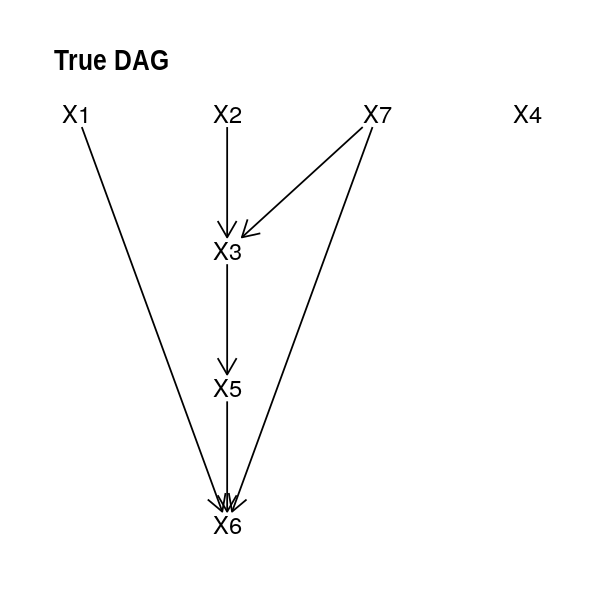

In [13]:
true.dag <- plot.adj(A)

options(repr.plot.width=5, repr.plot.height=5)
true.dag + ggtitle("True DAG")

We simulate data using the equation of the SEM above as:

In [14]:
Z <- matrix(rnorm(n * p, 0, 0.1), n)
X <- Z %*% solve(diag(p) - A)

head(X)

X1,X2,X3,X4,X5,X6,X7
0.01106827,0.04690320,0.1728460,0.08985497,0.06879523,0.1197701,0.05077993
-0.05558411,-0.02112469,-0.0027891,-0.02377340,0.00699006,-0.1163466,0.04613310
0.17869131,0.01870511,0.2489155,0.14634076,0.31859957,0.6472214,0.11794496
0.04978505,0.02275427,-0.1624462,0.01243783,-0.21683510,-0.3356445,-0.06793963
-0.19666172,-0.12619005,-0.1629389,0.14537408,-0.24879381,-0.5624779,-0.03186116
0.07013559,0.02855896,-0.1076570,0.03502270,-0.08467841,0.1235339,-0.06580193


To use GES, we first need to define a score object and provide the data as argument. In order to get the original GES algorithm by Chickering, we need to pass the phases as well (forward and backward), because the current implementation of the `pcalg` package uses an additional third phase.

In [15]:
score <- new("GaussL0penObsScore", X)
bn.ges <- pcalg::ges(score, phase = c("forward", "backward"))

From the fitted object we extract the graph first, turn it into a CPDAG and plot it. GES already computes a CPDAG, but it's just good practice to call the function regardless of the method we are using, since many methods merely return an element of the equivalence class and not the equivalence class itself. If one isn't aware of this and expects a CPDAG, it is easy to make incorrect causal claims (recall that we generally cannot distinguish the direction of edges in the linear Gaussian case unless a triple is a v-structure or would become one, if we reversed an edge).

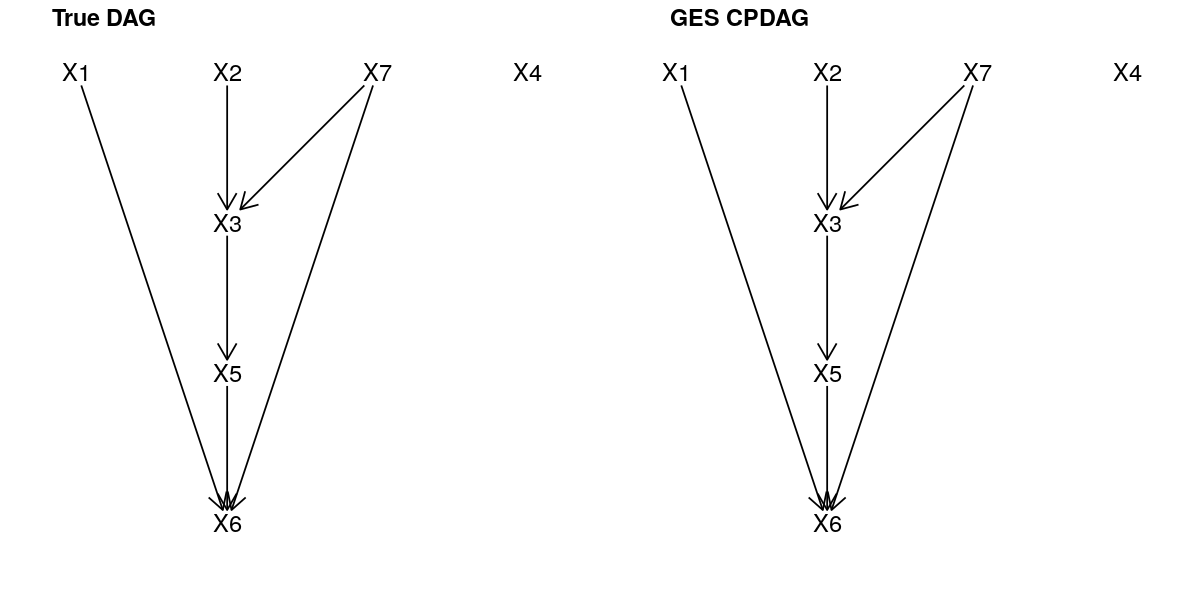

In [16]:
bn.ges.cpdag <- pcalg::getGraph(bn.ges$essgraph) %>%
    dag2cpdag() %>%
    igraph::graph_from_graphnel() %>%
    igraph::as_adj() %>%
    as.matrix() %>% 
    plot.adj()

options(repr.plot.width=10, repr.plot.height=5)
cowplot::plot_grid(true.dag, bn.ges.cpdag, ncol = 2, labels = c("True DAG", "GES CPDAG"))

That looks good. GES managed to correctly infer all the edges of the true DAG (including v-structures). This was expected, since the sample size is fairly high. Next we fit the autoencoder. DAG-GNN has several tuning paramameters. When testing the method, Lagrange multipliers $c$ and $\lambda$ with high values yielded the best results. Choices of $\alpha$ did not significantly change the output of the method. 

In [17]:
bn.gnn <- train(X, n_epochs = 1000, c=1000000, lambda=1000000, learning_rate=0.1)

Let's check if this is really a DAG first.

In [18]:
igraph::graph_from_adjacency_matrix(bn.gnn, weighted=TRUE) %>%
  is.dag()

[1] TRUE

As before we compute the CPDAG from the DAG and plot that. The result of the training is a weighted adjacency matrix which we first convert to a `graphNEL`, then to the CPDAG and then back to an adjacency matrix.

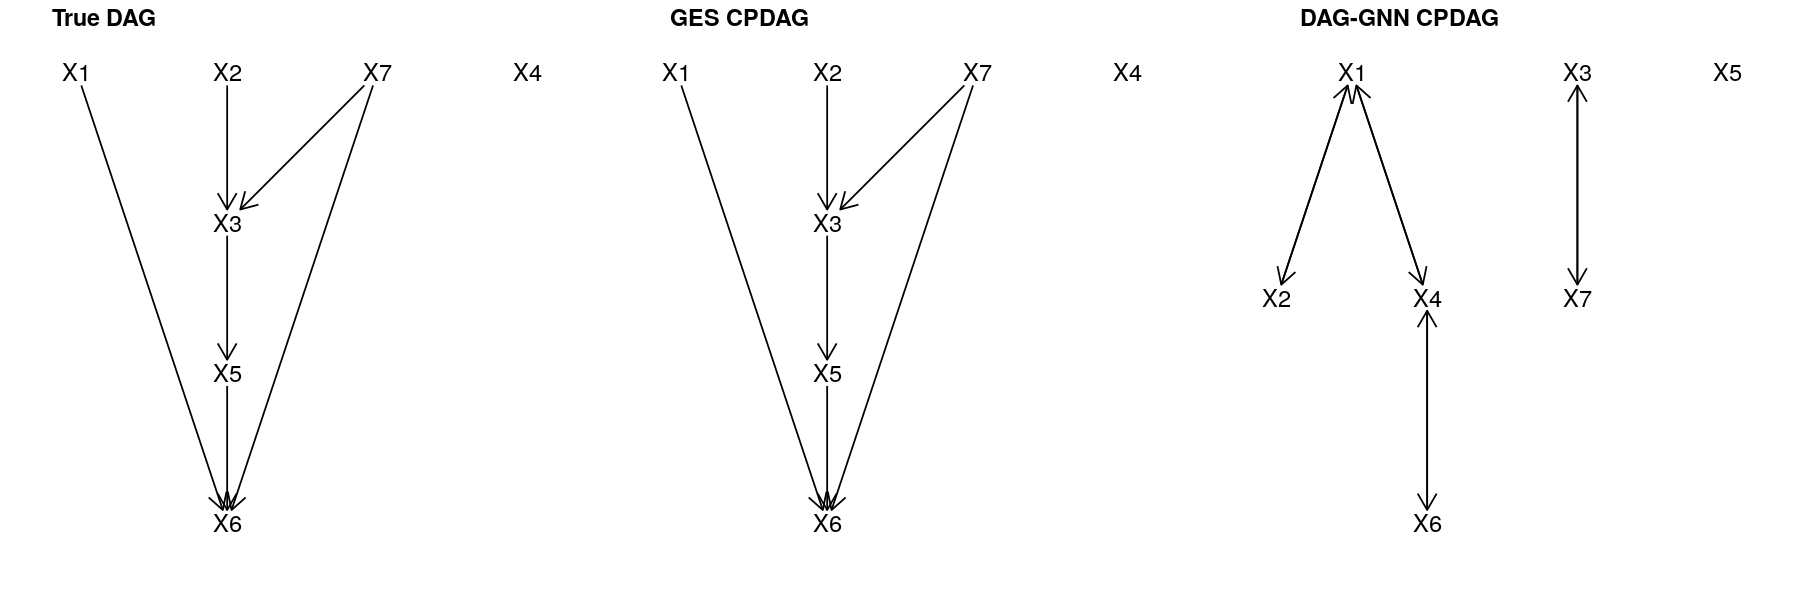

In [19]:
bn.daggnn.cpdag <- igraph::graph_from_adjacency_matrix(bn.gnn, weighted = TRUE) %>% 
  igraph::as_graphnel() %>%
  pcalg::dag2cpdag() %>%   
  igraph::graph_from_graphnel() %>%
  igraph::as_adj() %>%
  as.matrix() %>% 
  plot.adj()     

options(repr.plot.width=15, repr.plot.height=5)
cowplot::plot_grid(true.dag, bn.ges.cpdag, bn.daggnn.cpdag, ncol = 3,
                   labels = c("True DAG", "GES CPDAG", "DAG-GNN CPDAG"))

DAG-GNN, in this example, unfortunately wasn't able to recover the true DAG from the data and was easily outperformed by GES. I am not sure if this is due to a bug in the implementation, the data, the parameterization, or whatever (feedback on bugs would be welcome to simon.dirmeier@web.de).

Regardless, it impressively shows that classics with theoretical/asymptotic guarantees, like GES, still have their place in modern machine learning and should be considered in applications and benchmarks.

## License

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" align="left" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br>

The notebook is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.

## Session info

In [20]:
sessionInfo()

R version 4.0.0 (2020-04-24)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 19.10

Matrix products: default
BLAS/LAPACK: /usr/lib/x86_64-linux-gnu/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] pcalg_2.6-10           cowplot_1.0.0          forcats_0.5.0         
 [4] stringr_1.4.0          dplyr_0.8.5            purrr_0.3.4           
 [7] readr_1.3.1            tidyr_1.0.2            tibble_3.0.1          
[10] tidyverse_1.3.0        ggraph_2.0.2           ggplot2_3.3.0         
[13] igraph_1.2.5           kera